In [1]:
import sys
sys.path.append('../src')

import ipywidgets as widgets
import pandas as pd
import qiskit
import math

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute, BasicAer, Aer, transpile, assemble
from qiskit.tools.visualization import plot_histogram
from qiskit.converters import circuit_to_dag, dag_to_circuit
from collections import OrderedDict

from Crypto.Hash import Poly1305
from Crypto.Cipher import AES
from binascii import unhexlify
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib import cm
from matplotlib.backends.backend_agg import FigureCanvas

from random import sample
import numpy as np
from numpy.random import randint
import panel as pn
import copy

import qkd
pn.extension()
pn.extension('terminal')
pn.extension('ipywidgets')

import time

In [2]:
Aer.backends()

[AerSimulator('aer_simulator'),
 AerSimulator('aer_simulator_statevector'),
 AerSimulator('aer_simulator_density_matrix'),
 AerSimulator('aer_simulator_stabilizer'),
 AerSimulator('aer_simulator_matrix_product_state'),
 AerSimulator('aer_simulator_extended_stabilizer'),
 AerSimulator('aer_simulator_unitary'),
 AerSimulator('aer_simulator_superop'),
 QasmSimulator('qasm_simulator'),
 StatevectorSimulator('statevector_simulator'),
 UnitarySimulator('unitary_simulator'),
 PulseSimulator('pulse_simulator')]

In [3]:
dashboard = None
mac = None

In [4]:
temp_backend = Aer.get_backend("qasm_simulator")
temp_air_sim = temp_backend

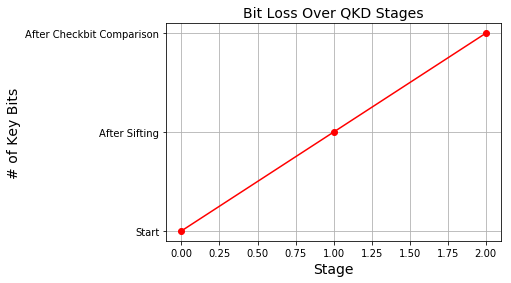

In [5]:
# Parameter selectors
n_bits = pn.widgets.IntInput(name="Number of Qubits", value=10, step=1, start=10, end=1000000)
displacement = pn.widgets.FloatSlider(name="Distance (km)", value=0, step=1, start=0, end=20)
#% to db: db = 10 log(1+%)
#db to %:%=(10^db/10)*100
#print(1-1/pow(10,(displacement.value*0.4+2)/10))
#print(1-1/pow(10,(displacement.start*0.4+2)/10))
#print(1-1/pow(10,(displacement.end*0.4+2)/10))
decoherence = pn.widgets.FloatSlider(name="Decoherence rate", value=1-1/pow(10,(displacement.value*0.4+2)/10), step=0.01, start=1-1/pow(10,(displacement.start*0.4+2)/10), end=1-1/pow(10,(displacement.end*0.4+2)/10))
timesl = pn.widgets.FloatSlider(name="Time to establish first key (km)", value=488-(7.19*displacement.value)+(1.5*pow(displacement.value,2)), step=5, start=488-(7.19*displacement.start)+(1.5*pow(displacement.start,2)), end=488-(7.19*displacement.end)+(1.5*pow(displacement.end,2)))
receiver = pn.widgets.Select(name="Target", options=['Bob', 'Test'])
checkbitRatio = pn.widgets.FloatSlider(name="Checkbit ratio",value = 0.33,step= 0.01,start = 0, end = 1)
checkbitThresh = pn.widgets.FloatSlider(name="Checkbit threshold",value = 0.33,step= 0.01,start = 0, end = 1)
## Greesan --> more inputs Code for  qprot, eavesdropping, and solutions
qprotgroup = pn.widgets.RadioButtonGroup(
    name='cb_qprot', options=['BB84','Ekert'])
eavebox = pn.widgets.Checkbox(name='Eavesdropping')
eaveslide = pn.widgets.FloatSlider(name="Leftover Eavesdropping rate", value=0, step=0.01, start=0, end=1)
#eaveslide = pn.widgets.FloatSlider(name="Leftover Eavesdropping rate", value=0, step=0.01, start=0, end=1-decoherence.value)
#eaveslide.link(decoherence,'value')
isolgroup = pn.widgets.CheckButtonGroup(
    name='cb_i_soln', options=['SDN', 'Poly1305-AES'])
isol2 = pn.widgets.CheckButtonGroup(
    name='cb_i_soln', options=['Cascade'])
updatebutton = pn.widgets.Button(name="Update Inputs",button_type='primary')
fig0 = Figure()
x = []
y = []
x += [0,1,2]
y += ['Start','After Sifting','After Checkbit Comparison']
plt.plot(x,y, color='red', marker='o')
plt.title('Bit Loss Over QKD Stages', fontsize=14)
plt.xlabel('Stage', fontsize=14)
plt.ylabel('# of Key Bits', fontsize=14)
plt.grid(True)
FigureCanvas(fig0)
mpl_pane = pn.pane.Matplotlib(fig0, dpi=144)
bitpreval = n_bits.value
dispreval = displacement.value
decopreval = decoherence.value
eaveprebool = eavebox.value
eavepreval = eaveslide.value
timepreval = timesl.value

Text(0.5,0.98,'Categorical Plotting')

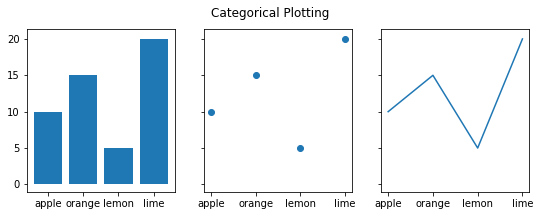

In [6]:
data = {'apple': 10, 'orange': 15, 'lemon': 5, 'lime': 20}
names = list(data.keys())
values = list(data.values())

fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharey=True)
axs[0].bar(names, values)
axs[1].scatter(names, values)
axs[2].plot(names, values)
fig.suptitle('Categorical Plotting')

In [7]:
keys = []
bases = []
encoded_output = []

bob_results = []
# Generate key
def generate_key(event=None):
    """
    Function for generating a random key and bases of length n.
    
    :param n: length of bitstring to generate
    """
    n = n_bits.value
    bit_key = randint(2, size=n)
    bit_basis = randint(2, size=n)
    
    keys.append(bit_key)
    bases.append(bit_basis)
    
    if select_auth.value == 'Poly1305':
        secret = b'Thirtytwo very very secret bytes'
        
        global mac
        mac = Poly1305.new(key=secret, cipher=AES)
        mac.update(b'Hello')
        print("Nonce: ", mac.nonce.hex())
        print("MAC:   ", mac.hexdigest())

        time.sleep(0.25)
        terminal.write("Nonce: " + str(mac.nonce.hex()) + "\n")
        time.sleep(0.25)
        terminal.write("MAC:   " + str(mac.hexdigest()) + "\n")
        time.sleep(0.25)
    
    
    
    terminal.write("\nGenerating " + str(n) + "-qubit key and basis ")
    for i in range(3):
        time.sleep(0.25)
        terminal.write(".")
    time.sleep(0.25)
    terminal.write(" Finished")
    time.sleep(0.4)
    terminal.write("\nAlice's Key: " + str(bit_key) + "\nAlice's EncodingBasis: " + str(bit_basis))
    
generate_button = pn.widgets.Button(name="Generate key")
generate_button.on_click(generate_key)

qubit_select = pn.widgets.Select(name="Qubit", options=[])

measure_button = pn.widgets.Button(name="Measure")
### Write code for key with eavesdropper with measure
# Outputs
terminal = pn.widgets.Terminal("Welcome to the QKD Simulator.\n\n", height=750, sizing_mode='stretch_width', options={"cursorBlink": True})
clear_terminal = pn.widgets.Button(name="Clear terminal")


send_button = pn.widgets.Button(name="Send")

measure_terminal = pn.widgets.Terminal(height=120, sizing_mode='stretch_width', options={"cursorBlink": True})

def send(event=None):
    #msg_receiver = receiver.value
    
    terminal.write("\nEncoding ")
    encode()
    for i in range(3):
        time.sleep(0.25)
        terminal.write(".")
    time.sleep(0.25)
    terminal.write(" Sent")
    time.sleep(0.4)
    
def encode(event=None):
    """
    Function for encoding a message.
    
    :param bit_key: Randomly generated bitstring key
    :param bit_bases: Bases for each bit in bit_key
    """
    bit_key = keys[-1]
    bit_bases = bases[-1]
    output = []
    
    # length of bit_key and bit_bases should be the same
    assert len(bit_key) == len(bit_bases), "Key and bases sequence should be equivalent."
    
    for i in range(len(bit_key)):
        qc = QuantumCircuit(1, 1)
        
        # Encode qubit in Z-basis (horizontal-vertical)
        if bit_bases[i] == 0:
            if bit_key[i] == 0:
                pass
            else:
                qc.x(0)
        
        # Encode qubit in X-basis (diagonal)
        else:
            if bit_key[i] == 0:
                qc.h(0)
            else:
                qc.x(0)
                qc.h(0)
                
        qc.barrier()
        output.append(qc)
        
    encoded_output.append(output)
    qubit_select.options += ["Qubit " + str(i) for i in range(len(output))]

send_button.on_click(send)
    
def delete_text(event=None):
    terminal.clear()

clear_terminal.on_click(delete_text)

In [8]:
def measure_qubits(event=None):
    measure_terminal.clear()
    measure_terminal.write("\nMeasuring ")
    for i in range(3):
        time.sleep(0.25)
        measure_terminal.write(".")
    time.sleep(0.25)
    measure_terminal.write(" Finished")
    time.sleep(0.4)
    
    noise = decoherence.value
    measure_terminal.write(noise)
    msg = encoded_output[-1]
    n = n_bits.value
    bases = randint(2, size=n)
    
    if noise > 0:
        
        #temp_backend = Aer.get_backend("aer_simulator")
        temp_results = []
        
        noise_idx = []
        for i_n in range(int(len(msg)*noise)):
            noise_idx.append(random.randint(0, len(msg)-1))
            
        for n_idx in noise_idx:
            # Z-basis
            if bases[n_idx] == 0: 
                msg[n_idx].measure(0, 0)

             # X-basis
            if bases[n_idx] == 1:
                msg[n_idx].h(0)
                msg[n_idx].measure(0, 0)
                
            #temp_aer_sim = Aer.get_backend("aer_simulator")
            temp_qobj = assemble(msg[n_idx], shots=1, memory=True)
            temp_sim_results = temp_aer_sim.run(temp_qobj).result()
            temp_measured_bit = int(temp_sim_results.get_memory()[0])
            temp_results.append(temp_measured_bit)
            
    secret = b'Thirtytwo very very secret bytes'
    mac = Poly1305.new(key=secret, cipher=AES)
    mac.update(b'Hello')
    print("Nonce: ", mac.nonce.hex())
    print("MAC:   ", mac.hexdigest())
    
    passed = False
    msg_ = b"I am Alice."
    
    nonce_hex = mac.nonce.hex()
    mac_tag_hex = mac.hexdigest()

    secret = b'Thirtytwo very very secret bytes'
    nonce = unhexlify(nonce_hex)
    mac = Poly1305.new(key=secret, nonce=nonce, cipher=AES, data=msg_)
    try:
        mac.hexverify(mac_tag_hex)
        print("\nThe message '%s' is authentic" % msg_)
        passed = True
    except ValueError:
        print("\nThe message or the key is wrong")
        passed = False
         
    backend = Aer.get_backend("aer_simulator")
    results = []
    
    for i in range(len(msg)):
        # Z-basis
        if bases[i] == 0: 
            msg[i].measure(0, 0)
            
         # X-basis
        if bases[i] == 1:
            msg[i].h(0)
            msg[i].measure(0, 0)
            
        aer_sim = Aer.get_backend("aer_simulator")
        qobj = assemble(msg[i], shots=1, memory=True)
        sim_results = aer_sim.run(qobj).result()
        measured_bit = int(sim_results.get_memory()[0])
        results.append(measured_bit)
        
    bob_results.append(results)
    
    
    if passed == True:
        alice_msg = str("\nThe message is authentic.")
        measure_terminal.write(alice_msg + "\n")
        measure_terminal.write("\nGenerated Key: "+ str(results))
    
    else:
        measure_terminal.write("\nThe message or the key is wrong. Terminating ")
        for i in range(3):
            time.sleep(0.25)
            measure_terminal.write(".")
        
        measure_terminal.write("\nSession ended.")
        


measure_button.on_click(measure_qubits)

select_auth = pn.widgets.Select(name="Authentication Protocol", options=["Poly1305", "AES", "ZKP"])

pre_shared = pn.widgets.TextInput(name="Pre-Shared Key", value='Thirty two very very secret bytes')

auth_input = pn.widgets.TextInput(name="Authentication Tag", value='Thirty two very very secret bytes')

#updash()

measurement = pn.Row(pn.WidgetBox(auth_input, measure_button, height=120), measure_terminal)

In [9]:
def generate_key2(n):
    """
    Function for generating a random key and bases of length n.
    
    :param n: length of bitstring to generate
    """
    bit_key = randint(2, size=n)
    bit_basis = randint(2, size=n)
    
    return bit_key, bit_basis

# Code for measuring
def encode2(bit_key, bit_bases):
    """
    Function for encoding a message.
    
    :param bit_key: Randomly generated bitstring key
    :param bit_bases: Bases for each bit in bit_key
    """
    output = []
    
    # length of bit_key and bit_bases should be the same
    assert len(bit_key) == len(bit_bases), "Key and bases sequence should be equivalent."
    
    for i in range(len(bit_key)):
        qc = QuantumCircuit(1, 1)
        
        # Encode qubit in Z-basis (horizontal-vertical)
        if bit_bases[i] == 0:
            if bit_key[i] == 0:
                pass
            else:
                qc.x(0)
        
        # Encode qubit in X-basis (diagonal)
        else:
            if bit_key[i] == 0:
                qc.h(0)
            else:
                qc.x(0)
                qc.h(0)
                
        qc.barrier()
        output.append(qc)
        
    return output

In [10]:
def encodeBits(abits,abasis):
    s = "["
    realqc = QuantumCircuit(len(abits),1)
    qc = QuantumCircuit(len(abits))
    for i in range(len(abits)):
        #qc.append(#QuantumCircuit(len(abits)))
        if abits[i] == 0:
            if abasis[i] == 0:
                s+='0'
            else:
                qc.h(i)
                realqc.h(i)
                s+='+'
        else:
            qc.x(i)
            realqc.x(i)
            if abasis[i] == 0:
                s+='1'
            else:
                qc.h(i)
                realqc.h(i)
                s+='-'
        if i < len(abits)-1:
            s+= " "
    qc.barrier()
    realqc.barrier()
    return (qc,realqc,s+"]")

In [11]:
def decomeasure(perc,qc,realqc,basis):
    measseq = []
    measgate = QuantumCircuit(1, name='NOISE')
    for i in range(len(basis)):
        #print("meas",i)
        if randint(0,100) < perc*100:
            #print(i,"is measured")
            qc.append(measuregate,[i])
            realqc.measure(i,0)
            measseq.append(i)
    qc.barrier()
    realqc.barrier()
    return (qc,realqc,measseq)

In [12]:
measuregate = QuantumCircuit(1, name='MEAS')
def eavesdrop(perc,qc,realqc,basis):
    eave = 0
    eavesucc = []
    eavefail = []
    eavesuccgate = QuantumCircuit(1, name='EAVECB') #CB --> correct basis
    eavefailgate = QuantumCircuit(1, name='EAVEWB') #WB --> wrong basis
    for i in range(len(basis)):
        if randint(0,100) < perc*100:
            #eavecnt+=1
            r = randint(0,1)
            if basis[i] == r:
                eavesucc.append(i)
                qc.append(eavesuccgate,[i])
            else:
                eavefail.append(i)
                qc.append(eavefailgate,[i])
            qc.append(measuregate,[i])
            if r == 1:
                qc.h(i)
            realqc.measure(i,0)
    qc.barrier()
    realqc.barrier()
    return (qc,realqc,eavesucc,eavefail)

In [13]:
def bobmeasure(qc,realqc,bobbasis,alicebasis):
    matchseq = []
    for i in range(len(bobbasis)):
        if bobbasis[i] == 1:
            qc.h(i)
            realqc.h(i)
        if bobbasis[i] == alicebasis[i]:
            matchseq.append(i)
            #print("bit " + str(i) + " matches")
        qc.append(measuregate,[i])
    for i in range(len(bobbasis)):
        realqc.measure(i,0)
    #realqc.measure(list(range(len(alicebasis))),0)
    return (qc,realqc,matchseq)

In [14]:
#using Geeks for Geeks as reference for array intersection code: https://www.geeksforgeeks.org/union-and-intersection-of-two-sorted-arrays-2/
def inter(arr1, arr2):
    i, j = 0, 0
    conjarr = []
    while i < len(arr1) and j < len(arr2):
        if arr1[i] < arr2[j]:
            i += 1
        elif arr1[i] > arr2[j]:
            j += 1
        else:
            conjarr.append(arr1[i])
            j += 1
            i += 1
    return conjarr

In [15]:
def un(arr1,arr2):
    conjarr = sorted(list(set(arr1) | set(arr2)))
    return conjarr

In [16]:
def aleft(arr1, arr2):
    i, j = 0, 0
    conjarr = []
    while i < len(arr1) and j < len(arr2):
        if arr1[i] < arr2[j]:
            conjarr.append(arr1[i])
            i += 1
        elif arr1[i] > arr2[j]:
            j += 1
        else:
            j += 1
            i += 1
    while i < len(arr1):
        conjarr.append(arr1[i])
        i+=1
    return conjarr

In [17]:
def dropbits(matchseq,bitLength):
    dropseq = []
    for i in range(bitLength):
        if i not in matchseq:
            dropseq.append(i)
    return dropseq

In [18]:
def statsfromqcirc(n_bits,eavesucc,eavefail,matchseq):
    """
    dropseq = []
    for i in n_bits:
        if i not in matchseq:
            dropseq.append(i)
            
    #qbitdropseq = matchseq
    esptr = 0
    efptr = 0
    mptr = 0
    """
    eavesuccmatch = inter(eavesucc,matchseq)
    eavefailmatch = inter(eavefail,matchseq)
    
    
    """
    while mptr < len(matchseq) and esptr < len(eavesucc) and efptr < len(eavefail):
        if eavesucc[esptr] == qbitdropseq[mptr] or eavefail[efptr] == qbitdropseq[mptr]:
            if eavesucc[esptr] == qbitdropseq[mptr]:
                eavesuccmatch.append(matchseq[mptr])
            if eavefail[efptr] == qbitdropseq[mptr]:
                eavefailmatch.append(matchseq[mptr])
            del qbitdropseq[mptr]
            mptr -= 1
        elif eavesucc[esptr] < qbitdropseq[mptr] or eavefail[efptr] < qbitdropseq[mptr]:
            if(eavesucc[esptr] < qbitdropseq[mptr]):
                while esptr < len(eavesucc) and eavesucc[esptr] < qbitdropseq[mptr]:
                    esptr += 1
            if (eavefail[efptr] < qbitdropseq[mptr]):
                while efptr < len(eavefail) and eavefail[efptr] < qbitdropseq[mptr]:
                    efptr += 1
        while mptr < len(matchseq) and eavesucc[esptr] > qbitdropseq[mptr] and eavefail[efptr] > qbitdropseq[mptr]:
            mptr += 1
        mptr+=1
    """
    eavefailrateb4sift = len(eavefail) #possible to alert Bob
    eavesuccrateb4sift = len(eavesucc) #possible to eavesdrop without letting Bob know
    return (eavefailrateb4sift, eavesuccrateb4sift, eavesuccmatch,eavefailmatch)

In [19]:
def remove_idle_qwires(circ,dropbits):
    #remove_arr = [1,2,3]
    i = 0
    while i < len(circ.data):
        #if len(circ.data[i][1]) > 1:
            #j = 0
            #while j < len(circ.data[i][1]):
            #    if circ.data[i][1][j].index in dropbits:
            #        del circ.data[]
        if circ.data[i][1][0].index in dropbits:
            #print("here")
            del circ.data[i]
            i-=1
        i+=1
    #print(qc.data)
    #qc.draw()
    return circ
    
    """
    dag = circuit_to_dag(circ)
    layers = list(dag.multigraph_layers())
    #print(dag)
    idle_wires = list(dag.idle_wires())
    #print(idle_wires)
    dag = circuit_to_dag(qc)
    layers = list(dag.multigraph_layers())

    n_remove = 2

    # the extra minus 1 since the last layer consists of output nodes (qubits and clbits).
    """
    """
    for layer in layers[- n_remove - 1:]:

        for node in layer:
            if node.type == 'op':
                dag.remove_op_node(node)
    """
 #   return (dag_to_circuit(dag),dag)

In [20]:
def remove_circuit_noise(qc,realqc,qbitdropseq):
    qcirc = remove_idle_qwires(qc,qbitdropseq)
    realqc = remove_idle_qwires(realqc,qbitdropseq)
    return (qcirc,realqc)

In [21]:
def genrand(n):
    bits = randint(2, size=n)
    return bits

In [22]:
def compare_seq(ratio,matchbits):
    numCheck = max(1,round(len(matchbits)*ratio))
    checkbits = sample(matchbits,numCheck)
    
    return sorted(checkbits)

In [23]:
def checkBits(checkbits,eavefail,measseq,thresh):
    cbcheck = inter(checkbits,measseq)
    left = aleft(checkbits,measseq)
    cbcheck2 = inter(checkbits,eavefail)
    cbcheck3 = un(cbcheck,cbcheck2)
    left = aleft(left,eavefail)
    succ = True
    ratio = len(cbcheck)/len(checkbits)
    if ratio>thresh:
        succ = False
    return(cbcheck,cbcheck2,cbcheck3,left,succ,ratio)

In [24]:
def bitSeqToBits(arr,bits):
    s = ""
    for i in arr:
        s+=str(bits[i])
    return s

In [25]:
def removeCheckBits(bits,matchbits,checkbits):
    return bitSeqToBits(aleft(matchbits,checkbits),bits)

In [65]:
def graph(bb,start,afterSift,afterCheck,AES,cascade,event=None):
    fig = Figure()
    ax = fig.add_subplot(111)
    FigureCanvas(fig)
    x = []
    y = []
    if bb:
        x += ['Start','After Sifting','After cb Comparison']
        y += [start,afterSift,afterCheck]
    FigureCanvas(fig)
    ax.plot(x,y,color='red', marker='o')
    ax.set_title("Bit Loss by QKD Stage")
    ax.set_xlabel('Stage')
    ax.set_ylabel('# of Key Bits')
    ax.set_figheight(15)
    ax.set_figwidth(15)
    #pane = pn.pane.Matplotlib(fig, dpi=144)
    return fig

In [27]:
qc = None
bb84flag = False
Ekertflag = False
def on_BB84(eaves,eaveprebool,eavesperc,eavepreval,decoperc,decopreval,bitval,bitpreval,event=None):
    global bb84flag
    global Ekertflag
    global qc
    global terminal
    if not bb84flag or eavesperc!=eavepreval or decoperc!=decopreval or bitval != bitpreval:
        terminal.clear()
        terminal.write("BB84\n")
        (alicebits,alicebasis) = generate_key2(n_bits.value)
        terminal.write("Alice Bits:               " + str(alicebits) + "\n")
        terminal.write("Alice Encoding Basis:     " + str(alicebasis) + "\n")
        (visqc,qc,s) = encodeBits(alicebits,alicebasis)
        terminal.write("Alice Bits After Encoding:" + s + "\n")
        if decoperc>0:
            visqc,qc,decohereseq = decomeasure(decoperc,visqc,qc,alicebasis)
        terminal.write(str(len(decohereseq)) + " bits lost due to noise")
        eavesucc = []
        #siftedqubits = []
        if eaves and eavesperc>0:
            print("hi")
            (visqc,qc,eavesucc,eavefail) = eavesdrop(eavesperc,visqc,qc,alicebasis)
            terminal.write("\nEavesdropping attempted on:"+ str(eavesucc) + str(eavefail) + " bits")
            
        bobbasis = genrand(n_bits.value)
        terminal.write("\nBob Decoding Basis:       " + str(bobbasis) + "\n")
        (visqc,qc,matchseq) = bobmeasure(visqc,qc,bobbasis,alicebasis)
        siftedqubits = dropbits(matchseq,n_bits.value)
        terminal.write("Alice and Bob matching basis sequence:" + str(matchseq))
        terminal.write("Alice and Bob mismatching basis sequence:" + str(siftedqubits))
        terminal.write("\nBits lost due to Bob's wrong basis selection:       " + str(len(alicebits)-len(matchseq)) + "\n")
        terminal.write(visqc.draw(output="text"))
        terminal.write("\n")
        eavefailrate = []
        #qbitdropseq, eavefailrate, eavefailrateaftersift,eavesuccrateaftersift
        if eaves and eavesperc>0:
            #print("hi2")
            (eavefailrate, eavesuccrate, eavesuccaftersift, eavefailaftersift) = statsfromqcirc(len(alicebits),eavesucc,eavefail,matchseq)
            #print(siftedqubits)
            terminal.write("eavesuccseq after sift:" + str(eavesuccaftersift) + "\neavesfailseq after sift:" +  str(eavefailaftersift))
            terminal.write("\nbefore sifting:\neavesdropper alert rate is " + str(eavefailrate) + "/" + str(len(alicebits)) + 
            "\neavesdropper success rate is " + str(eavesuccrate) + "/" + str(len(alicebits)) + 
            "\nafter sifting:\neavesdropper alert rate is " + str(len(eavefailaftersift)) + "/" + str(len(matchseq)) +
            "\neavesdropper success rate is " + str(len(eavesuccaftersift)) + "/" + str(len(matchseq)))
        (visqc,qc) = remove_circuit_noise(visqc,qc,siftedqubits)
        terminal.write("\nupdated circuit after sifting process\n")
        terminal.write(visqc.draw(output="text"))
        checkseq = compare_seq(checkbitRatio.value,matchseq)
        (checkbit1,checkbit2,checkbit3,bitsLeft,succ,ratio) = checkBits(checkseq,eavefailrate,decohereseq,checkbitThresh.value)
        #terminal.write("\ncb1"+str(checkbit1))
        #terminal.write("\ncb2"+str(checkbit2))
        #terminal.write("\ncb3"+str(checkbit3))
        #terminal.write("\ncheckseq:" + str(checkseq))
        #terminal.write("\nmeasseq:" + str(decohereseq))
        #terminal.write("\neavefailseq:" + str(eavefailrate))
        #terminal.write("\ncheckeaveinter" + str(checkeaveinter))
        terminal.write("\nAlice and bob compare bits:" + str(checkseq))
        if not succ:
            terminal.write("\nAs eavedropping failure + measure rate after sifting:" + str(ratio) + "\nis greater than threshold rate in the checkbits compared: " + str(checkbitThresh.value) + "\nQKD has failed, please try again with larger key size\n")
            mpl_pane.object = graph(True,n_bits.value,len(siftedqubits),0,False,False)
        else:
            terminal.write("\nAs eavedropping failure + measure rate after sifting:" + str(ratio) + "\nis less than threshold rate in the checkbits compared:" + str(checkbitThresh.value) + "\nQKD has succeeded\n")
            keyAfterBB84 = removeCheckBits(alicebits,matchseq,checkseq)
            terminal.write("key is: " + keyAfterBB84)
            mpl_pane.object = graph(True,n_bits.value,len(siftedqubits),len(keyAfterBB84),False,False)
        #terminal.write(dag)
    bb84flag = True
    Ekertflag = False
    #inputs: coherence
    #inputs: #bits
    #outputs:

In [28]:
def on_Ekert(event=None):
    global bb84flag
    global Ekertflag
    if not Ekertflag:
        terminal.clear()
        terminal.write("Ekert91\n")
        print("")
    bb84flag = False
    Ekertflag = True

In [29]:
def on_eavesdrop(event=None):
    a = True
    #ouputs ->reveal eavesdropping ratio --> terminal displays eavesdropping content

In [30]:
def on_SDN(event=None):
    a = True

In [31]:
def on_Poly1305AES(event=None):
    a = True

In [32]:
def on_Cascade(event=None):
    a = True

In [33]:
def updash(event=None):
    global dashboard
    dashboard = pn.Column(pn.Row(pn.WidgetBox(pre_shared, n_bits, decoherence, displacement, timesl, qprotgroup, checkbitRatio, checkbitThresh, eavebox, eaveslide, isolgroup, isol2, updatebutton, generate_button, clear_terminal, send_button,height=700),
    terminal),pn.WidgetBox(mpl_pane))
updash()

In [34]:
def update(event=None):
    global isolgroup
    global eavebox
    global eaveslide
    global timesl
    global displacement
    global decoherence
    global bitpreval
    global decopreval
    global dispreval
    global timepreval
    global eaveprebool
    global eavepreval
    #global terminal
    #print(eavebox)
    #print(eavebox.value)
    #pn.pane.Matplotlib(fig0, dpi=144)
    if eavebox.value:
        #isolgroup = pn.widgets.CheckButtonGroup(name='cb_i_soln', options=['SDN', 'Poly1305-AES', 'Cascade'])
        eaveslide.disabled = False
        if eaveslide.value > 0:
            isolgroup.disabled = False
        else:
            isolgroup.disabled = True
        if eaveslide.value>0 or decoherence.value>0:
            isol2.disabled = False
        else:
            isol2.disabled = True
        #eaveslide.end = 1-decoherence.value
        eavenoise = eaveslide.value + decoherence.value
        on_eavesdrop()
    else:
        #isolgroup = pn.widgets.CheckButtonGroup(name='cb_i_soln', options=['SDN', 'Poly1305-AES', 'Cascade'],disabled=True)
        eaveslide.disabled = True
        isolgroup.disabled = True
        if decoherence.value > 0:
            isol2.disabled = False
        else:
            isol2.disabled = True
        eavenoise = decoherence.value
    slideflag = True
    #coherence = displacement.value*0.4+2
    #time = 488-(7.19*displacement.value)+(1.5*displacement.value*displacement.value)
    #coh=1-1/pow(10,(displacement.value*0.4+2)/10)
    #disp = 
    
    if slideflag and decopreval != decoherence.value:
        displacement.value = (-2.5)*(10*math.log10(1-decoherence.value)+2)
        timesl.value = 488-(7.19*displacement.value)+(1.5*pow(displacement.value,2))
        #print(displacement.value,timesl.value)
        slideflag = False
    if slideflag and dispreval != displacement.value:
        decoherence.value = 1-1/pow(10,(displacement.value*0.4+2)/10)
        timesl.value = 488-(7.19*displacement.value)+(1.5*pow(displacement.value,2))
        #print(decoherence.value,timesl.value)
        slideflag = False
    if slideflag and timepreval != timesl.value:
        displacement.value = math.sqrt((timesl.value-479)*2/3)+2.4
        decoherence.value = 1-1/pow(10,(displacement.value*0.4+2)/10)
        #print(displacement.value,decoherence.value)
        slideflag = False
    dispreval = displacement.value
    timepreval = timesl.value
    if qprotgroup.value == "Ekert":
        on_Ekert()
    else:
        on_BB84(eavebox.value,eaveprebool,eaveslide.value,eavepreval,decoherence.value,decopreval,n_bits.value,bitpreval)
        bitpreval = n_bits.value
        #terminal.write(n_bits.value)
        decopreval = decoherence.value
        eaveprebool = eavebox.value
        eavepreval = eaveslide.value
    #print(isolgroup.value)
    if isolgroup.value and len(isolgroup.value)>0:
        if "SDN" in isolgroup.value:
            print("SDN Activated")
            on_SDN()
        if "Poly1305-AES" in isolgroup.value:
            print("AES Activated")
            on_Poly1305AES()
    #print(isol2.value)
    if isol2.value and len(isol2.value)>0 and isol2.value[0]:
        print("Cascade Activated")
        on_Cascade()
    #updash()
updatebutton.on_click(update)
        

In [35]:
#isolgroup = pn.widgets.CheckButtonGroup(
#    name='cb_i_soln', options=['SDN', 'Poly1305-AES', 'Cascade'],disabled=True)
#dashboard = updash()
#dashboard

Column
    [0] Row
        [0] WidgetBox(height=700)
            [0] TextInput(name='Pre-Shared Key', value='Thirty two very v...)
            [1] IntInput(end=1000000, name='Number of Qubits', start=10, value=10)
            [2] FloatSlider(end=0.9, name='Decoherence rate', start=0.36904265551980675, step=0.01, value=0.44904265551980677)
            [3] FloatSlider(end=20, name='Distance (km)', step=1, value=1.47205058106327)
            [4] FloatSlider(end=944.2, name='Time to establish f..., start=488.0, step=5, value=480.66635569196814)
            [5] RadioButtonGroup(name='cb_qprot', options=['BB84', 'Ekert'], value='BB84')
            [6] FloatSlider(name='Checkbit ratio', step=0.01, value=0.33)
            [7] FloatSlider(name='Checkbit threshold', step=0.01, value=0.33)
            [8] Checkbox(name='Eavesdropping')
            [9] FloatSlider(disabled=True, name='Leftover Eavesdropping r..., step=0.01)
            [10] CheckButtonGroup(disabled=True, name='cb_i_soln', options=['SDN', 'Poly1305-AES'])
            [11] CheckButtonGroup(name='cb_i_soln', options=['Cascade'])
            [12] Button(button_type='primary', clicks=2, name='Update Inputs')
            [13] Button(name='Generate key')
            [14] Button(name='Clear terminal')
            [15] Button(name='Send')
        [1] Terminal(id=4841245944)
    [1] WidgetBox
        [0] Matplotlib(Figure)
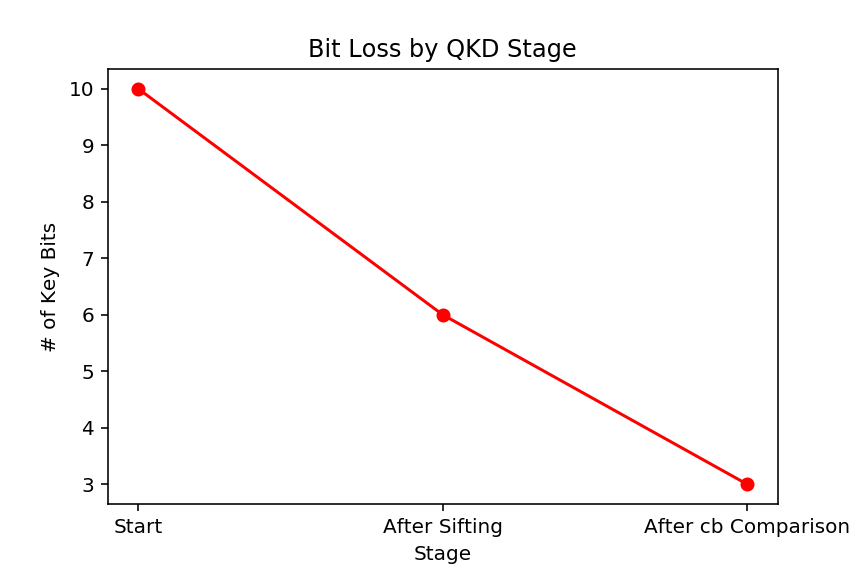

In [66]:
update()
dashboard

In [37]:
qc.draw()

q_0: ───────────────────────────────────
     ┌───┐┌───┐┌───┐     ┌─┐            
q_1: ┤ X ├┤ H ├┤ H ├─────┤M├────────────
     └───┘└───┘└───┘     └╥┘            
q_2: ─────────────────────╫─────────────
                          ║ ┌─┐         
q_3: ─────────────────────╫─┤M├─────────
                          ║ └╥┘┌─┐      
q_4: ─────────────────────╫──╫─┤M├──────
                          ║  ║ └╥┘      
q_5: ─────────────────────╫──╫──╫───────
                          ║  ║  ║       
q_6: ─────────────────────╫──╫──╫───────
                          ║  ║  ║       
q_7: ─────────────────────╫──╫──╫───────
     ┌───┐┌───┐ ┌─┐ ┌───┐ ║  ║  ║ ┌─┐   
q_8: ┤ X ├┤ H ├─┤M├─┤ H ├─╫──╫──╫─┤M├───
     └───┘└───┘ └╥┘ └┬─┬┘ ║  ║  ║ └╥┘┌─┐
q_9: ────────────╫───┤M├──╫──╫──╫──╫─┤M├
                 ║   └╥┘  ║  ║  ║  ║ └╥┘
c: 1/════════════╩════╩═══╩══╩══╩══╩══╩═
                 0    0   0  0  0  0  0

In [38]:
update()

In [39]:
print(qc)

                                        
q_0: ───────────────────────────────────
     ┌───┐┌───┐┌───┐     ┌─┐            
q_1: ┤ X ├┤ H ├┤ H ├─────┤M├────────────
     └───┘└───┘└───┘     └╥┘            
q_2: ─────────────────────╫─────────────
                          ║ ┌─┐         
q_3: ─────────────────────╫─┤M├─────────
                          ║ └╥┘┌─┐      
q_4: ─────────────────────╫──╫─┤M├──────
                          ║  ║ └╥┘      
q_5: ─────────────────────╫──╫──╫───────
                          ║  ║  ║       
q_6: ─────────────────────╫──╫──╫───────
                          ║  ║  ║       
q_7: ─────────────────────╫──╫──╫───────
     ┌───┐┌───┐ ┌─┐ ┌───┐ ║  ║  ║ ┌─┐   
q_8: ┤ X ├┤ H ├─┤M├─┤ H ├─╫──╫──╫─┤M├───
     └───┘└───┘ └╥┘ └┬─┬┘ ║  ║  ║ └╥┘┌─┐
q_9: ────────────╫───┤M├──╫──╫──╫──╫─┤M├
                 ║   └╥┘  ║  ║  ║  ║ └╥┘
c: 1/════════════╩════╩═══╩══╩══╩══╩══╩═
                 0    0   0  0  0  0  0 


In [40]:
#dag = circuit_to_dag(qc)
#dag.draw()

In [41]:
qb = copy.deepcopy(qc)

In [42]:
qc.draw()

q_0: ───────────────────────────────────
     ┌───┐┌───┐┌───┐     ┌─┐            
q_1: ┤ X ├┤ H ├┤ H ├─────┤M├────────────
     └───┘└───┘└───┘     └╥┘            
q_2: ─────────────────────╫─────────────
                          ║ ┌─┐         
q_3: ─────────────────────╫─┤M├─────────
                          ║ └╥┘┌─┐      
q_4: ─────────────────────╫──╫─┤M├──────
                          ║  ║ └╥┘      
q_5: ─────────────────────╫──╫──╫───────
                          ║  ║  ║       
q_6: ─────────────────────╫──╫──╫───────
                          ║  ║  ║       
q_7: ─────────────────────╫──╫──╫───────
     ┌───┐┌───┐ ┌─┐ ┌───┐ ║  ║  ║ ┌─┐   
q_8: ┤ X ├┤ H ├─┤M├─┤ H ├─╫──╫──╫─┤M├───
     └───┘└───┘ └╥┘ └┬─┬┘ ║  ║  ║ └╥┘┌─┐
q_9: ────────────╫───┤M├──╫──╫──╫──╫─┤M├
                 ║   └╥┘  ║  ║  ║  ║ └╥┘
c: 1/════════════╩════╩═══╩══╩══╩══╩══╩═
                 0    0   0  0  0  0  0

In [43]:
#remove_arr = [1,2,3]
def dropper():
    drop = [7,3,5,9]
    i = 0
    while i < len(qb.data):
        """
        if len(qc.data[i][1]) > 1:
            j = 0
            while j < len(qc.data[i][1]):
                if qc.data[i][1][j].index in drop:
                    #print("inside")
                    j+=1
                    #del circ.data[]
        """
        if qb.data[i][1][0].index in drop:
            #print("here")
            del qb.data[i]
            i-=1
        i+=1
    print(qb.data)
    return qb
dropper().draw()

[(Instruction(name='x', num_qubits=1, num_clbits=0, params=[]), [Qubit(QuantumRegister(10, 'q'), 1)], []), (Instruction(name='h', num_qubits=1, num_clbits=0, params=[]), [Qubit(QuantumRegister(10, 'q'), 1)], []), (Instruction(name='x', num_qubits=1, num_clbits=0, params=[]), [Qubit(QuantumRegister(10, 'q'), 8)], []), (Instruction(name='h', num_qubits=1, num_clbits=0, params=[]), [Qubit(QuantumRegister(10, 'q'), 8)], []), (Instruction(name='measure', num_qubits=1, num_clbits=1, params=[]), [Qubit(QuantumRegister(10, 'q'), 8)], [Clbit(ClassicalRegister(1, 'c'), 0)]), (Instruction(name='h', num_qubits=1, num_clbits=0, params=[]), [Qubit(QuantumRegister(10, 'q'), 1)], []), (Instruction(name='h', num_qubits=1, num_clbits=0, params=[]), [Qubit(QuantumRegister(10, 'q'), 8)], []), (Instruction(name='measure', num_qubits=1, num_clbits=1, params=[]), [Qubit(QuantumRegister(10, 'q'), 1)], [Clbit(ClassicalRegister(1, 'c'), 0)]), (Instruction(name='measure', num_qubits=1, num_clbits=1, params=[]), 

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  from ipykernel import kernelapp as app


q_0: ─────────────────────────────
     ┌───┐┌───┐┌───┐     ┌─┐      
q_1: ┤ X ├┤ H ├┤ H ├─────┤M├──────
     └───┘└───┘└───┘     └╥┘      
q_2: ─────────────────────╫───────
                          ║       
q_3: ─────────────────────╫───────
                          ║ ┌─┐   
q_4: ─────────────────────╫─┤M├───
                          ║ └╥┘   
q_5: ─────────────────────╫──╫────
                          ║  ║    
q_6: ─────────────────────╫──╫────
                          ║  ║    
q_7: ─────────────────────╫──╫────
     ┌───┐┌───┐ ┌─┐ ┌───┐ ║  ║ ┌─┐
q_8: ┤ X ├┤ H ├─┤M├─┤ H ├─╫──╫─┤M├
     └───┘└───┘ └╥┘ └───┘ ║  ║ └╥┘
q_9: ────────────╫────────╫──╫──╫─
                 ║        ║  ║  ║ 
c: 1/════════════╩════════╩══╩══╩═
                 0        0  0  0

In [44]:
#dag = circuit_to_dag(qc)
#layers = list(dag.multigraph_layers())
#removelist = ["q_1","q_2","q_3"]

#for i in removelist:
#    for node in dag.nodes_on_wire(i,only_ops = True):
#        dag.remove_op_node(node)
    #if node.wire in removelist:
    #dag.remove_descendants_of(node,only_ops = True)
    #dag.remove_op_node(node)
#n_remove = 2

# the extra minus 1 since the last layer consists of output nodes (qubits and clbits).
#for i in removelist:
#    layer = layers[i]
#    for node in layer:
#        if node.type == 'op':
#            dag.remove_op_node(node)
#new_qc = dag_to_circuit(dag)

#print(new_qc)

In [45]:
measurement

Row
    [0] WidgetBox(height=120)
        [0] TextInput(name='Authentication Tag', value='Thirty two very v...)
        [1] Button(name='Measure')
    [1] Terminal(id=4841246056)

In [46]:
# pn.Row(pn.WidgetBox(qubit_select, height=75), qubit_select, height=100)

In [47]:
# static_text = pn.widgets.StaticText(value=qubit_select.options[0].draw())
# static_text

In [48]:
# qubit_select.options[0].draw()

In [49]:
if mac:
    mac.nonce.hex()

In [50]:
mac

In [51]:
# network table

network = pd.DataFrame(columns=["Alice", "Bob", "Public"])
network

,Alice,Bob,Public


In [52]:
n = 100

alice_key, alice_basis = generate_key2(n)

In [53]:
alice_key

array([1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1,
       0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1])

In [54]:
import time
import datetime

int(time.time()) // 1000

1654213

In [55]:
# Allowed delay
delay_threshold = 10 * 60 # 10 minutes

# Alice time
t_alice = time.time()

# Alice seed
alice_init_seed = int(np.ceil(t_alice / delay_threshold))
alice_init_seed

2757022

In [56]:
# Bob time
t_bob = time.time()

# Bob seed
bob_init_seed = int((t_bob+delay_threshold) / delay_threshold)
bob_init_seed

2757022

In [57]:
def generate_seed(init_seed):
    return np.abs(hash(str(init_seed)) // (2**32 - 1))

In [58]:
np.random.seed(generate_seed(alice_init_seed))

def generate_pad(n):
    return randint(2, size=n)

alice_otp = generate_pad(100)
alice_otp

array([0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1,
       0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1,
       0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0])

In [59]:
np.random.seed(generate_seed(bob_init_seed))

bob_otp = generate_pad(100)
bob_otp

array([0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1,
       0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1,
       0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0])

In [60]:
alice_otp == bob_otp

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [61]:
s = "01100110011001100110011001100110"
j = int(s, 2)
print(j)
print(bin(j))


1717986918
0b1100110011001100110011001100110


In [62]:
key = b'Sixteen byte key'
cipher = AES.new(key, AES.MODE_EAX)
print(cipher)